In [3]:
!export https_proxy=http://127.0.0.1:7890 http_proxy=http://127.0.0.1:7890 all_proxy=socks5://127.0.0.1:7890 ALL_PROXY=socks5://127.0.0.1:7890

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sys
import os

sys.path.append("..")
sys.path.append("../src")
from src import RUGDH5Dataset, DeepEvidentialSegModelConfig, FPNFeatureExtractorConfig, PatchDecoderConfig
from src.utils import image_reverse_transforms, label2name
from src import TRAIN_STAGE
import torch.nn.functional as F

In [2]:
def visualize_with_legend(ax, mask, title, label2name):
    unique_labels = np.unique(mask)
    base_cmap = plt.get_cmap('tab20b', 25) 
    im = ax.imshow(mask, cmap=base_cmap, vmin=0, vmax=24)
    ax.set_title(title)
    legend_patches = []
    for label_idx in unique_labels:
        if label_idx in label2name:
            color = base_cmap(label_idx / 24.0) 
            patch = mpatches.Patch(color=color, label=f"{label_idx}: {label2name[label_idx]}")
            legend_patches.append(patch)
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


In [3]:
# 1. 设置设备与加载数据
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = RUGDH5Dataset('../data/rugd_test.h5')

# 2. 初始化模型 (必须设为 NORMALIZING_FLOW 阶段)
model_config = DeepEvidentialSegModelConfig(
    feature_extractor_config=FPNFeatureExtractorConfig(),
    patch_decoder_config=PatchDecoderConfig(),
    num_classes=20,
    train_stage=TRAIN_STAGE.NORMALIZING_FLOW,
)
model = model_config.make_model(device=device)

# 3. 加载最新的 Stage 2 权重
ckpt_path = '../checkpoints/stage2_evidential/stage2_epoch_50.pth'
if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt)
    print(f"Successfully loaded weights from {ckpt_path}")
else:
    print("Weight file not found! Please check the path.")

Successfully loaded weights from ../checkpoints/stage2_evidential/stage2_epoch_50.pth


In [12]:
# 4. 获取随机样本并进行推理
idx = torch.randint(0, len(dataset), (1,)).item()
print(f'idx:{idx}')
image, label = dataset[idx]
raw_image = image_reverse_transforms(image).permute(1, 2, 0).cpu().numpy()

model.eval()
with torch.no_grad():
    input_tensor = image.unsqueeze(0).to(device)
    
    # 1. 得到分割结果并计算 probs
    _, logits, _ = model.classify(input_tensor)
    # !!! 必须在这里定义 probs，确保它随图片更新 !!!
    probs = torch.softmax(logits, dim=1) 
    predicted_label = torch.argmax(logits, dim=1).cpu().squeeze().numpy()
    
    # 2. --- 分块计算全图密度 (避免 OOM) ---
    features = model.feature_extractor.get_pixel_wise_features(input_tensor)
    features = model.feature_norm(features) 
    B_f, C_f, H_f, W_f = features.shape
    feat_flat = features.permute(0, 2, 3, 1).reshape(-1, C_f)
    
    chunk_size = 5000
    log_densities = []
    for i in range(0, feat_flat.shape[0], chunk_size):
        chunk = feat_flat[i : i + chunk_size]
        log_densities.append(model.density_estimator(chunk))
    
    log_density_map = torch.cat(log_densities).view(H_f, W_f).cpu().numpy()

    # 1. 获取基础密度
    dens_min = log_density_map.min()
    dens_max = log_density_map.max()
    
    # 2. 线性归一化到 [0, 1]
    norm_density = (log_density_map - dens_min) / (dens_max - dens_min + 1e-6)
    
    # 3. 上采样 (使用 fresh 的 logits 形状)
    norm_density_large = F.interpolate(
        torch.from_numpy(norm_density).unsqueeze(0).unsqueeze(0).to(device),
        size=(logits.shape[2], logits.shape[3]),
        mode='bilinear',
        align_corners=False
    ).squeeze().cpu().numpy()

    # 4. 认知不确定性 (Epistemic)
    base_epistemic = 1.0 - norm_density_large
    power = 6.0
    epistemic_map = np.power(base_epistemic, power)

    # 5. 偶然不确定性 (Aleatoric) - 现在使用的是当前图的 probs
    max_probs, _ = torch.max(probs, dim=1)
    base_aleatoric = (1.0 - max_probs.squeeze().cpu().numpy())
    # 这里的对比度增强
    aleatoric_map = np.power(base_aleatoric, 4.0)

print(f"Current Image Index: {idx}")
print(f"Log Density Range: {log_density_map.min():.2f} to {log_density_map.max():.2f}")

idx:627
Current Image Index: 627
Log Density Range: -111.45 to -96.62


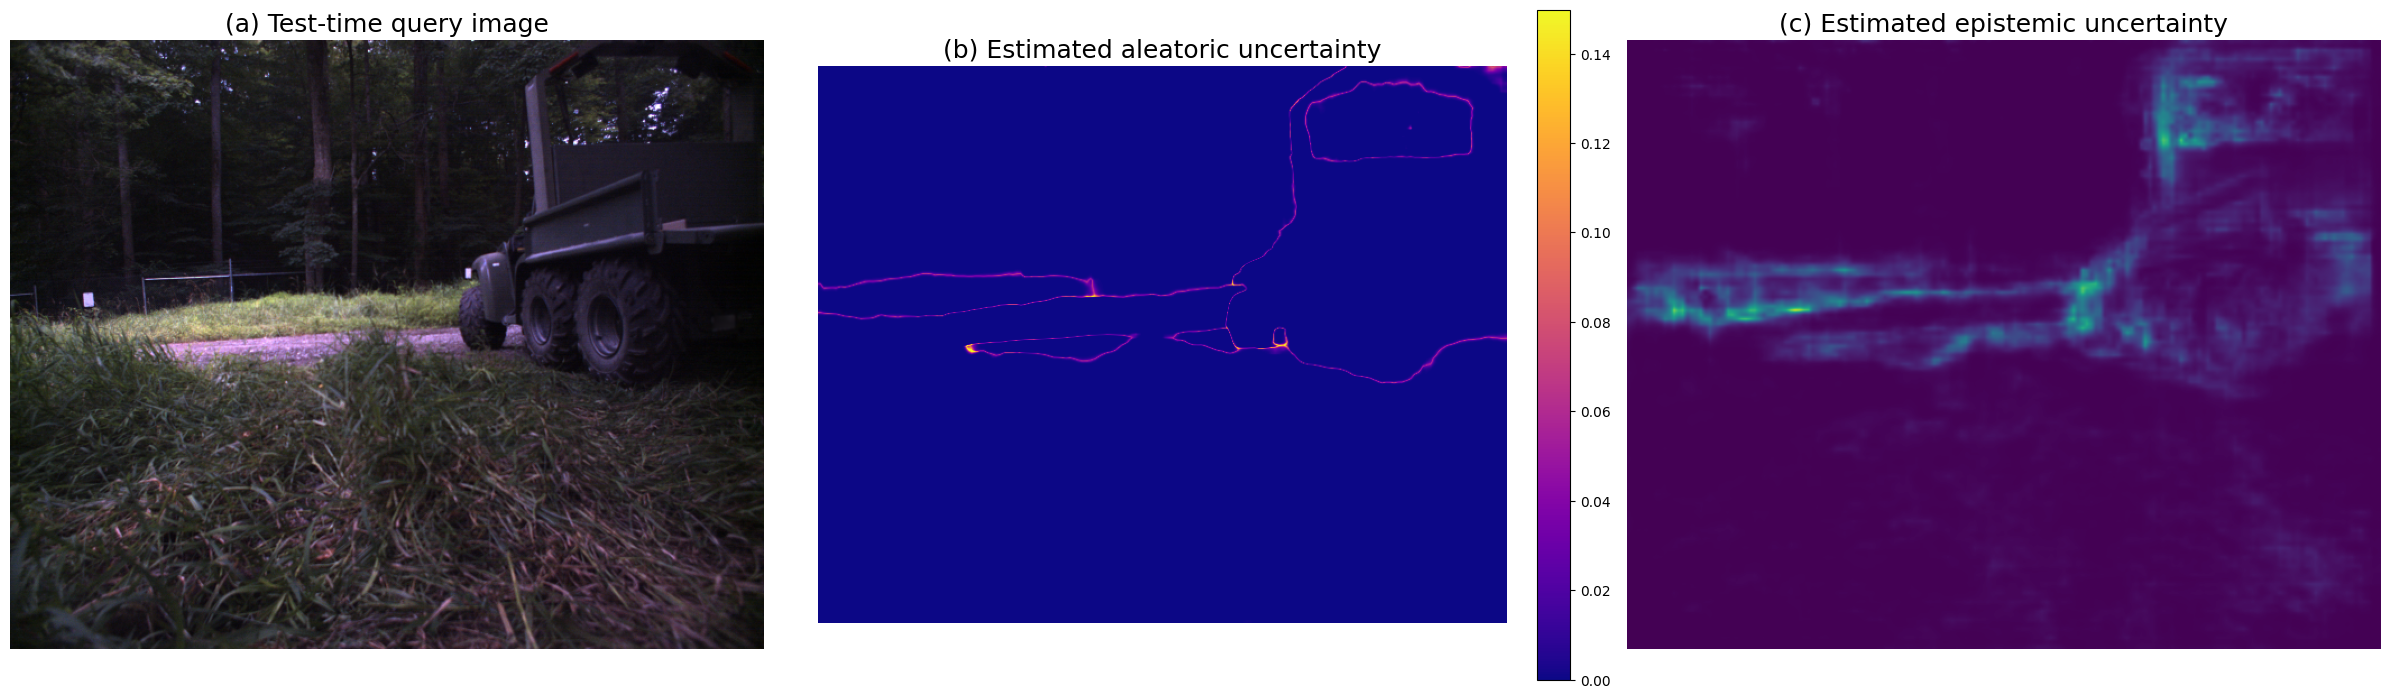

In [13]:
# 5. 最终绘图
fig, ax = plt.subplots(1, 3, figsize=(24, 7), facecolor='white')

# (a) 原图
ax[0].imshow(raw_image)
ax[0].set_title("(a) Test-time query image", fontsize=18)
ax[0].axis('off')

# (b) Aleatoric - 偶然不确定性
# 使用 plasma，由于 Aleatoric 通常数值较小，我们手动设一个 vmax 让边缘更亮
im_ale = ax[1].imshow(aleatoric_map, cmap='plasma', vmin=0, vmax=aleatoric_map.max()*0.8)
ax[1].set_title("(b) Estimated aleatoric uncertainty", fontsize=18)
ax[1].axis('off')
plt.colorbar(im_ale, ax=ax[1], fraction=0.046, pad=0.04)

# (c) Epistemic - 认知不确定性
# 这里的 vmin=0, vmax=1.0 非常关键，配合上面的幂次变换
im_epi = ax[2].imshow(epistemic_map, cmap='viridis', vmin=0, vmax=1.0)
ax[2].set_title("(c) Estimated epistemic uncertainty", fontsize=18)
ax[2].axis('off')
# 注意：如果还是觉得黄，可以手动减小分母：vmax=epistemic_map.max()*0.9

plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import precision_recall_curve, auc

# 1. 根据 RUGD 数据集定义 ID 和 OOD 索引
# 参考：src/utils.py 中的 label2name
# ID (16类)
ID_INDICES = [0, 2, 3, 4, 5, 7, 10, 11, 13, 14, 15, 18, 19, 20, 21, 23]
# OOD (8类 - 障碍物)
OOD_INDICES = [6, 8, 9, 12, 17, 22, 24] 

def calculate_brier_score(probs, targets, num_classes=20):
    # probs: [N, C], targets: [N]
    one_hot = F.one_hot(targets, num_classes=num_classes).float()
    return torch.mean(torch.sum((probs - one_hot)**2, dim=1))

def calculate_auc_pr(y_true, y_scores):
    # y_true: 0 or 1, y_scores: probability/uncertainty
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return auc(recall, precision)

In [15]:
# 评估设置
num_eval_images = 100
num_classes = 20
all_results = {
    "id_log_p": [], "id_correct": [], "id_entropy": [], 
    "id_probs": [], "id_labels": [], # 增加 id_labels 存储
    "id_brier": [], "id_density": [], "ood_density": []
}

model.eval()
print(f"Collecting data for Table I (RUGD - Red Columns)...")

for i in range(num_eval_images):
    img, lbl = dataset[i]
    img_t = img.unsqueeze(0).to(device)
    lbl_t = torch.from_numpy(lbl).long().to(device)
    
    with torch.no_grad():
        _, logits, _ = model.classify(img_t)
        probs = torch.softmax(logits, dim=1)
        conf, pred = torch.max(probs, dim=1)
        entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=1).squeeze()
        
        # 密度计算
        feats = model.feature_norm(model.feature_extractor.get_pixel_wise_features(img_t))
        f_flat = feats.permute(0, 2, 3, 1).reshape(-1, feats.shape[1])
        l_dens = torch.cat([model.density_estimator(f_flat[j:j+5000]) for j in range(0, f_flat.shape[0], 5000)])
        log_d = F.interpolate(l_dens.view(1, 1, feats.shape[2], feats.shape[3]), 
                              size=lbl.shape, mode='bilinear').squeeze()
        
        # 掩码
        mask_in_range = (lbl_t >= 0) & (lbl_t < num_classes)
        mask_id = torch.isin(lbl_t, torch.tensor(ID_INDICES).to(device)) & mask_in_range
        mask_ood = torch.isin(lbl_t, torch.tensor(OOD_INDICES).to(device)) | (lbl_t >= num_classes)
        
        if mask_id.any():
            target_probs = probs.squeeze().permute(1, 2, 0)[mask_id]
            target_labels = lbl_t[mask_id]
            
            # 存储数据
            all_results["id_log_p"].append(torch.log(target_probs.gather(1, target_labels.unsqueeze(1)) + 1e-10).cpu().numpy())
            
            one_hot = F.one_hot(target_labels, num_classes=num_classes).float()
            brier_pixel = torch.sum((target_probs - one_hot)**2, dim=1)
            all_results["id_brier"].append(brier_pixel.cpu().numpy())
            
            all_results["id_correct"].append((pred.squeeze()[mask_id] == target_labels).cpu().numpy())
            all_results["id_entropy"].append(entropy[mask_id].cpu().numpy())
            all_results["id_probs"].append(target_probs.cpu().numpy()) 
            all_results["id_labels"].append(target_labels.cpu().numpy()) # 存下真实标签
            all_results["id_density"].append(log_d[mask_id].cpu().numpy())
            
        if mask_ood.any():
            all_results["ood_density"].append(log_d[mask_ood].cpu().numpy())

    if (i+1) % 10 == 0: print(f"Processed {i+1}/{num_eval_images}")

Processed 10/100
Processed 20/100
Processed 30/100
Processed 40/100
Processed 50/100
Processed 60/100
Processed 70/100
Processed 80/100
Processed 90/100
Processed 100/100


In [16]:
from sklearn.metrics import precision_recall_curve, auc

# 合并所有采集到的数据
id_log_p = np.concatenate(all_results["id_log_p"])
id_brier = np.concatenate(all_results["id_brier"])
id_acc = np.concatenate(all_results["id_correct"])
id_ent = np.concatenate(all_results["id_entropy"])
id_probs = np.concatenate(all_results["id_probs"])
id_labels = np.concatenate(all_results["id_labels"])
id_dens = np.concatenate(all_results["id_density"])
ood_dens = np.concatenate(all_results["ood_density"])

# 计算 ECE 的函数
def fast_ece(probs, labels, n_bins=15):
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)
    accuracies = (predictions == labels)
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    ece = 0
    for i in range(n_bins):
        mask = (confidences > bin_boundaries[i]) & (confidences <= bin_boundaries[i+1])
        if np.any(mask):
            # |准确率 - 置信度| * 样本占比
            ece += np.abs(np.mean(accuracies[mask]) - np.mean(confidences[mask])) * (np.sum(mask) / len(confidences))
    return ece

# 计算 AUC-PR 的函数
def calculate_auc_pr(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return auc(recall, precision)

print("\n" + "="*60)
print("  TABLE I REPRODUCTION: RUGD DATASET (LEFT RED COLUMNS)")
print("="*60)

# 1. log-probability (ID) ↑
print(f"1. Log-probability (ID) ↑      : {id_log_p.mean():.4f}")

# 2. Brier score (ID) ↓
print(f"2. Brier score (ID) ↓          : {id_brier.mean():.4f}")

# 3. ECE (ID) ↓
print(f"3. ECE (ID) ↓                  : {fast_ece(id_probs, id_labels):.4f}")

# 4. AUC-PR unc. v. acc. ↑ (错误分类的检测能力)
auc_pr_unc = calculate_auc_pr(1 - id_acc, id_ent)
print(f"4. AUC-PR (unc. v. acc.) ↑     : {auc_pr_unc:.4f}")

# 5. log-density of ID ↑
print(f"5. Log-density of ID ↑         : {id_dens.mean():.2f}")

# 6. log-density of OOD ↓
print(f"6. Log-density of OOD ↓        : {ood_dens.mean():.2f}")

# 7. AUC-PR density v. ID ↑ (OOD 物体的识别能力)
y_true_id = np.concatenate([np.ones_like(id_dens), np.zeros_like(ood_dens)])
y_scores_dens = np.concatenate([id_dens, ood_dens])
auc_pr_dens = calculate_auc_pr(y_true_id, y_scores_dens)
print(f"7. AUC-PR (density v. ID) ↑    : {auc_pr_dens:.4f}")

print("="*60)
print("请将以上 7 个数字填写在 Table I 的每格左侧（RUGD 红色背景列）。")


  TABLE I REPRODUCTION: RUGD DATASET (LEFT RED COLUMNS)
1. Log-probability (ID) ↑      : -0.7098
2. Brier score (ID) ↓          : 0.2305
3. ECE (ID) ↓                  : 0.0937
4. AUC-PR (unc. v. acc.) ↑     : 0.4250
5. Log-density of ID ↑         : -102.82
6. Log-density of OOD ↓        : -104.69
7. AUC-PR (density v. ID) ↑    : 0.9361
请将以上 7 个数字填写在 Table I 的每格左侧（RUGD 红色背景列）。
